<a href="https://colab.research.google.com/github/Kuhlman-Lab/ThermoMPNN-D/blob/ThermoMPNN-I/ThermoMPNN_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**This is a Colab implementation of ThermoMPNN-I**</center>

---

ThermoMPNN-I is an experimental version of ThermoMPNN for predicting insertion and deletion (indel) mutations alongside substitutions. It was trained using the indel subset of the Megascale dataset used for vanilla ThermoMPNN.

### **COLAB TIPS:**
- The cells of this notebook are meant to be executed *in order*, so users should start from the top and work their way down.
- Executable cells can be run by clicking the PLAY button (>) that appears when you hover over each cell, or by using **Shift+Enter**.
- Make sure GPU is enabled by checking `Runtime` -> `Change Runtime Type`
  - Make sure that `Runtime type` is set to `Python 3`
  - Make sure that `Hardware accelerator` is set to `GPU`
  - Click `Save` to confirm

- If the notebook freezes up or otherwise crashes, go to `Runtime` -> `Restart Runtime` and try again.


In [1]:
%%capture

#@title # 1. Set up **ThermoMPNN environment**
#@markdown Import ThermoMPNN and its dependencies to this session. This may take a minute or two.

#@markdown You only need to do this once *per session*. To re-run ThermoMPNN on a new protein, you may start on Step 3.

#@markdown ---

# cleaning out any remaining data
!cd /content
!rm -rf /content/ThermoMPNN
!rm -rf /content/sample_data
!rm /content/*.pdb
!rm /content/*.csv

# import ThermoMPNN-D github repo
import os
if not os.path.exists("/content/ThermoMPNN-D"):
  !git clone https://github.com/Kuhlman-Lab/ThermoMPNN-D.git
  %cd /content/ThermoMPNN-D

! git checkout ThermoMPNN-I

# downloading various dependencies - add more if needed later
! pip install omegaconf wandb pytorch-lightning biopython nglview


In [3]:
#@title # **2. Set up ThermoMPNN imports and functions**

# Setting up imports and functions for use later in the protocol

from google.colab import files
import os
import sys
from urllib import request
from urllib.error import HTTPError
from google.colab._message import MessageError

import torch
import sys
import numpy as np
from dataclasses import dataclass
from Bio.PDB import PDBParser
from omegaconf import OmegaConf
import pandas as pd
from copy import deepcopy
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

tMPNN_path = '/content/ThermoMPNN-D'
if tMPNN_path not in sys.path:
  sys.path.append(tMPNN_path)

from thermompnn.datasets.dataset_utils import Mutation
from thermompnn.datasets.v2_datasets import tied_featurize_mut

from thermompnn.train_thermompnn import parse_cfg
from thermompnn.trainer.v2_trainer import TransferModelPLv2

def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID e.g. '3ICB' or '3icb'
    :param datadir: The directory where the downloaded file will be saved
    :param downloadurl: The base PDB download URL, cf.
        `https://www.rcsb.org/pages/download/http#structures` for details
    :return: the full path to the downloaded PDB file or None if something went wrong
    """

    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        request.urlretrieve(url, outfnm)
        return outfnm
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None

def alt_parse_PDB_biounits(x, atoms=['N', 'CA', 'C'], chain=None):
    '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''

    alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
    states = len(alpha_1)
    alpha_3 = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'GAP']

    aa_1_N = {a: n for n, a in enumerate(alpha_1)}
    aa_3_N = {a: n for n, a in enumerate(alpha_3)}
    aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
    aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
    aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

    def AA_to_N(x):
        # ["ARND"] -> [[0,1,2,3]]
        x = np.array(x);
        if x.ndim == 0: x = x[None]
        return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

    def N_to_AA(x):
        # [[0,1,2,3]] -> ["ARND"]
        x = np.array(x);
        if x.ndim == 1: x = x[None]
        return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

    xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
    resn_list = []
    for line in open(x, "rb"):
        line = line.decode("utf-8", "ignore").rstrip()

        # handling MSE and SEC residues
        if line[:6] == "HETATM" and line[17:17 + 3] == "MSE":
            line = line.replace("HETATM", "ATOM  ")
            line = line.replace("MSE", "MET")
        elif line[17:17 + 3] == "MSE":
            line = line.replace("MSE", "MET")
        elif line[17:17 + 3] == "SEC":
            line = line.replace("SEC", "CYS")

        if line[:4] == "ATOM":
            ch = line[21:22]
            if ch == chain or chain is None:
                atom = line[12:12 + 4].strip()
                resi = line[17:17 + 3]
                resn = line[22:22 + 5].strip()

                # RAW resn is defined HERE
                if resn not in resn_list:
                  resn_list.append(resn) # NEED to keep ins code here
                x, y, z = [float(line[i:(i + 8)]) for i in [30, 38, 46]]
                if resn[-1].isalpha():
                    resa, resn = resn[-1], int(resn[:-1]) - 1
                else:
                    resa, resn = "", int(resn) - 1
                if resn < min_resn:
                    min_resn = resn
                if resn > max_resn:
                    max_resn = resn
                if resn not in xyz:
                    xyz[resn] = {}
                if resa not in xyz[resn]:
                    xyz[resn][resa] = {}
                if resn not in seq:
                    seq[resn] = {}
                if resa not in seq[resn]:
                    seq[resn][resa] = resi

                if atom not in xyz[resn][resa]:
                    xyz[resn][resa][atom] = np.array([x, y, z])
                # print(resn_list)

    # convert to numpy arrays, fill in missing values
    seq_, xyz_ = [], []
    # print(seq)
    try:
        for resn in range(min_resn, max_resn + 1):
            if resn in seq:
              # CLEANED resn is defined HERE
                # resn_list.append(str(resn + 1))
                # print(resn)
                for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k], 20))
            else:
                seq_.append(20)

            if resn in xyz:
                for k in sorted(xyz[resn]):
                    for atom in atoms:
                        if atom in xyz[resn][k]:
                            xyz_.append(xyz[resn][k][atom])
                        else:
                            xyz_.append(np.full(3, np.nan))
            else:
                for atom in atoms: xyz_.append(np.full(3, np.nan))
        return np.array(xyz_).reshape(-1, len(atoms), 3), N_to_AA(np.array(seq_)), list(dict.fromkeys(resn_list))
    except TypeError:
        return 'no_chain', 'no_chain', 'no_chain'

def alt_parse_PDB(path_to_pdb, input_chain_list=None, ca_only=False, side_chains=False, mut_chain=None):
    c = 0
    pdb_dict_list = []
    init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                     'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
                     'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet

    if input_chain_list:
        chain_alphabet = input_chain_list

    biounit_names = [path_to_pdb]
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ''
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {}
        for letter in chain_alphabet:
            if ca_only:
                sidechain_atoms = ['CA']
            elif side_chains:
                sidechain_atoms = ["N", "CA", "C", "O", "CB",
                                   "CG", "CG1", "OG1", "OG2", "CG2", "OG", "SG",
                                   "CD", "SD", "CD1", "ND1", "CD2", "OD1", "OD2", "ND2",
                                   "CE", "CE1", "NE1", "OE1", "NE2", "OE2", "NE", "CE2", "CE3",
                                   "NZ", "CZ", "CZ2", "CZ3", "CH2", "OH", "NH1", "NH2"]
            else:
                sidechain_atoms = ['N', 'CA', 'C', 'O']
            xyz, seq, resn_list = alt_parse_PDB_biounits(biounit, atoms=sidechain_atoms, chain=letter)
            if mut_chain is not None:
              if resn_list != 'no_chain' and letter in mut_chain:
                  my_dict['resn_list'] = list(resn_list)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict['seq_chain_' + letter] = seq[0]
                coords_dict_chain = {}
                if ca_only:
                    coords_dict_chain['CA_chain_' + letter] = xyz.tolist()
                elif side_chains:
                    coords_dict_chain['SG_chain_' + letter] = xyz[:, 11].tolist()
                else:
                    coords_dict_chain['N_chain_' + letter] = xyz[:, 0, :].tolist()
                    coords_dict_chain['CA_chain_' + letter] = xyz[:, 1, :].tolist()
                    coords_dict_chain['C_chain_' + letter] = xyz[:, 2, :].tolist()
                    coords_dict_chain['O_chain_' + letter] = xyz[:, 3, :].tolist()
                my_dict['coords_chain_' + letter] = coords_dict_chain
                s += 1

        fi = biounit.rfind("/")
        if mut_chain is None:
          my_dict['resn_list'] = list(resn_list)
        my_dict['name'] = biounit[(fi + 1):-4]
        my_dict['num_of_chains'] = s
        my_dict['seq'] = concat_seq
        # my_dict['resn_list'] = list(resn_list)
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c += 1
    return pdb_dict_list

def get_chains(pdb):
  # collect list of chains in PDB to match with input
  parser = PDBParser(QUIET=True)
  structure = parser.get_structure('', pdb)
  chains = [c.id for c in structure.get_chains()]
  return chains

def run_inference(model, dataloader):
  """Run inference on full SSM dataset"""
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  model.cuda(device)
  model.eval()

  preds = []

  for batch in tqdm(dataloader):
    X, S, mask, lengths, chain_M, chain_encoding_all, residue_idx, mut_positions, mut_wildtype_AAs, mut_mutant_AAs, mut_ddGs, atom_mask = batch
    X = X.to(device)
    S = S.to(device)
    mask = mask.to(device)
    lengths = torch.Tensor(lengths).to(device)
    chain_M = chain_M.to(device)
    chain_encoding_all = chain_encoding_all.to(device)
    residue_idx = residue_idx.to(device)
    mut_positions = mut_positions.to(device)
    mut_wildtype_AAs = mut_wildtype_AAs.to(device)
    mut_mutant_AAs = mut_mutant_AAs.to(device)
    mut_ddGs = mut_ddGs.to(device)
    atom_mask = torch.Tensor(atom_mask).to(device)
    pred, _ = model(X, S, mask, chain_M, residue_idx, chain_encoding_all, mut_positions, mut_wildtype_AAs, mut_mutant_AAs, mut_ddGs, atom_mask)

    preds += list(torch.squeeze(pred, dim=-1).detach().cpu())
  print('%s mutations evaluated' % (str(len(preds))))
  return np.squeeze(preds)

class SSMDataset(Dataset):
  def __init__(self, pdb_data, alphabet):
    self.pdb_data = pdb_data
    self.alphabet = alphabet
    # configure SSM dataframe to run

    mut_list = []
    true_ids = []
    for pos, wtAA in enumerate(self.pdb_data['seq']):
      for mutAA in alphabet:
        mut_info = f'{wtAA}{pos + 1}{mutAA}'
        mut_list.append(mut_info)
        true_ids.append(self.pdb_data['resn_list'][pos])

    self.df = pd.DataFrame({
        'mut_info': mut_list,
        'pos_PDB': true_ids
    })

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    row = self.df.iloc[index]
    wtAA = row.mut_info[0]
    mutAA = row.mut_info[-1]
    pos = int(row.mut_info[1:-1]) - 1

    sample = deepcopy(self.pdb_data)
    sample['mutation'] = Mutation([pos], [wtAA], [mutAA], None, '')

    return sample



/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
# %%capture
#@title # **3. Upload or Fetch Input Data**

#@markdown ## You may either specify a PDB code to fetch or upload a custom PDB file.<br><br>

# -------- Collecting Settings for ThermoMPNN run --------- #

!rm /content/*.pdb &> /dev/null

#@markdown PDB code (example: 1PGA):
PDB = "1PGA" #@param {type: "string"}

#@markdown Upload Custom PDB?
Custom = False #@param {type: "boolean"}
#@markdown NOTE: If enabled, a `Choose files` button will appear at the bottom of this cell once this cell is run.

#@markdown Chain(s) of Interest (example: A,B,C):
Chains = "A" #@param {type:"string"}

#@markdown NOTE: If left blank, ThermoMPNN will use ALL chains in the PDB.

#@markdown ## **MODEL SETTINGS**


#@markdown Include Cysteines?
Include = True #@param {type: "boolean"}
#@markdown NOTE: Due to assay artifacts surrounding disulfide formation, model predictions for surface cysteine mutations may be overly favorable.

# try to upload the PDB file to Colab servers
if Custom:
  try:
    uploaded_pdb = files.upload()
    for fn in uploaded_pdb.keys():
      PDB = os.path.basename(fn)
      if not PDB.endswith('.pdb'):
        raise ValueError(f"Uploaded file {PDB} does not end in '.pdb'. Please check and rename file as needed.")
      os.rename(fn, os.path.join("/content/", PDB))
      pdb_file = os.path.join("/content/", PDB)
  except (MessageError, FileNotFoundError):
    print('\n', '*' * 100, '\n')
    print('Sorry, your input file failed to upload. Please try the backup upload procedure (next cell).')

else:
  try:
    fn = download_pdb(PDB, "/content/")
    if fn is None:
      raise ValueError("Failed to fetch PDB from RSCB. Please double-check PDB code and try again.")
    else:
      pdb_file = fn
  except HTTPError:
    raise HTTPError(f"No protein with code {PDB} exists in RSCB PDB. Please double-check PDB code and try again.")


In [ ]:
#@title # **3. Backup Data Upload (ONLY needed if initial upload failed)**

#@markdown ## If your file failed to upload automatically, you can do so manually by following these steps.<br><br>

#@markdown #### 1. Click the "Files" icon on the left toolbar. This will open the Colab server file folder.

#@markdown #### 2. The only thing in this folder should be "ThermoMPNN" directory. If any other files are in here, delete them.

#@markdown #### 3. Click the "Upload to session storage" button under the "Files" header. Choose your file for upload.

#@markdown #### 4. Run this cell. ThermoMPNN will find your file in session storage and use it.

#@markdown Chain(s) of Interest (example: A,B,C):
Chains = "A" #@param {type:"string"}

#@markdown ## **MODEL SETTINGS**
PDB = ""

#@markdown Include Cysteines?
Include = True #@param {type: "boolean"}
#@markdown NOTE: Due to assay artifacts surrounding disulfide formation, model predictions for surface cysteine mutations may be overly favorable.

import os

files = sorted(os.listdir('/content/'))
files = [f for f in files if f.endswith('.pdb')]

if len(files) < 1:
  raise ValueError('No PDB file found. Please upload your file before running this cell. Make sure it has a .pdb suffix.')
elif len(files) > 1:
  raise ValueError('Too many PDB files found. Please clear out any other PDBs before running this cell.')
else:
  pdb_file = os.path.join("/content/", files[0])
  print('Successfully uploaded PDB file %s' % (files[0]))

In [6]:
%%capture
#@markdown # **4. Run Model**

#@markdown Enable multi-chain inference?
Enable = True #@param {type: "boolean"}
#@markdown NOTE: This setting has not been validated and may encounter some parsing/memory errors for large proteins.

# ---------- PDB Parsing and Dataset Creation ---------- #


# use input_chain_list to grab correct protein chain
chain_list = Chains.strip().split(',')

pdb_chains = get_chains(pdb_file)
if len(chain_list) < 1:
  chain_list = pdb_chains

for ch in pdb_chains:
  assert ch in pdb_chains, f"Chain {ch} not found in PDB file with chains {pdb_chains}"

print(f'Using ThermoMPNN-I to predict stability across chain(s): {chain_list}')

# remove cys from alphabet if needed
if Include:
  alphabet = 'ACDEFGHIKLMNPQRSTVWYZag'
else: # skip cys mutations
  alphabet = 'ADEFGHIKLMNPQRSTVWYZag'

# load PDB using custom parser
pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list)[0]

num_total_res = len(pdb_dict['seq'])
print(f'Loaded {num_total_res} residues for inference')

ds = SSMDataset(pdb_dict, alphabet)
dl = DataLoader(ds, batch_size=256, shuffle=False,
                collate_fn=lambda b: tied_featurize_mut(b, side_chains=False, indels=True))

# load model
config = OmegaConf.merge(
    OmegaConf.load('/content/ThermoMPNN-D/examples/configs/indel.yaml'),
    OmegaConf.load('/content/ThermoMPNN-D/examples/configs/local.yaml')
)

config = parse_cfg(config)
config.platform.thermompnn_dir = '/content/ThermoMPNN-D'

# load single mutant model
model_path = '/content/ThermoMPNN-D/model_weights/ThermoMPNN-I.ckpt'
model = TransferModelPLv2.load_from_checkpoint(checkpoint_path=model_path, cfg=config, device='gpu')

# run inference routine
results = run_inference(model, dl)

In [23]:
#@title # **5. Postprocessing**

#@markdown ### Explicitly penalize disulfide breakage (recommended)?
Penalize = True #@param {type: "boolean"}

# collect output and generate files
df = ds.df
df['ddG (kcal/mol)'] = results

# rename indel mutations to be human readable
df['wtAA'] = df['mut_info'].str[0]
df['mutAA'] = df['mut_info'].str[-1]
df['pos'] = df['mut_info'].str[1:-1]

df['mutAA'] = df['mutAA'].replace(to_replace={'Z': 'del', 'a': 'insA', 'g': 'insG'})

# clean up DF
df['Mutation (PDB Numbered)'] = df['wtAA'] + df['pos_PDB'] + df['mutAA']
df['Mutation (ThermoMPNN Numbered)'] = df['wtAA'] + df['pos'] + df['mutAA']

# --------
if Penalize:
  # re-load PDB with side chains enabled
  pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list, side_chains=True)

  # collect all SG coordinates from all chains
  coords_all = [k for k in pdb_dict[0].keys() if k.startswith('coords')]
  chains = [c[-1] for c in coords_all]
  sg_coords = [pdb_dict[0][c][f'SG_chain_{chain}'] for c, chain in zip(coords_all, chains)]
  sg_coords = np.concatenate(sg_coords, axis=0)

  # calculate pairwise distance and threshold to find disulfides
  from scipy.spatial.distance import cdist
  dist = cdist(sg_coords, sg_coords)
  dist = np.nan_to_num(dist, 10000)
  hits = np.where((dist < 3) & (dist > 0)) # tuple of two [N] arrays of indices


  # match hit indices to actual resns for penalty
  all_resns = pdb_dict[0]['resn_list']
  bad_resns = []
  for h in hits[0]:
    bad_resns.append(all_resns[h])

  print('Identified the following disulfide engaged residues:', bad_resns)

  # apply penalty
  penalty = 2  # in kcal/mol - higher is less stable
  mask = df['pos'].isin(bad_resns) & (df['wtAA'] != df['mutAA'])

  df.loc[mask, 'ddG (kcal/mol)'] = df.loc[mask, 'ddG (kcal/mol)'] + penalty



Identified the following disulfide engaged residues: []


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

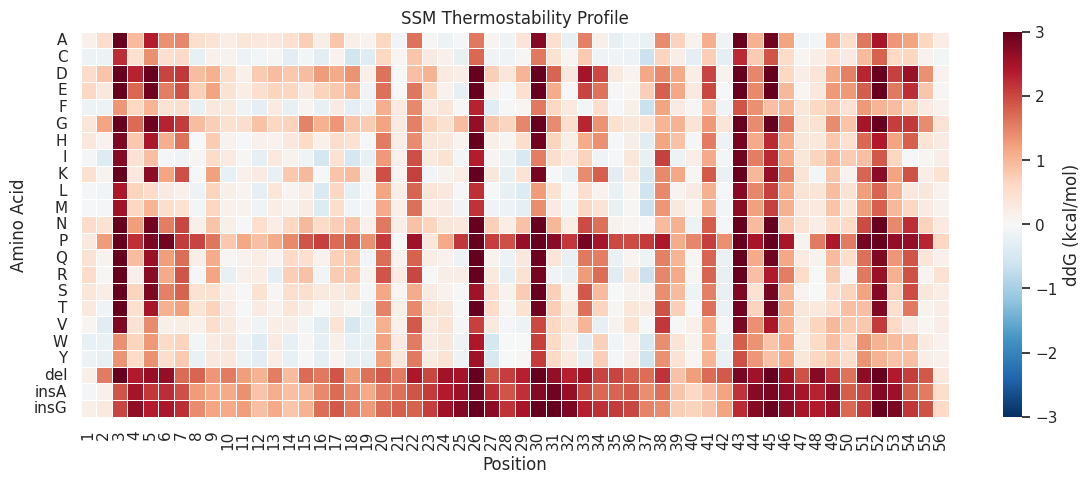

In [20]:
#@title # **6. Generate ddG Heatmap**

alphabet = [aa for aa in alphabet][:-3] + ['del', 'insA', 'insG'] # adjust to match new indel names

#@markdown Download heatmap?
Heatmap = False #@param {type: "boolean"}

# generate heatmap
import seaborn as sns
import matplotlib.pyplot as plt

positions = df['pos'].unique()
arr = np.zeros((positions.size, len(alphabet)), dtype=float)
for p_idx, p in enumerate(positions):
  for a_idx, a in enumerate(alphabet):
    arr[p_idx, a_idx] = df.loc[(df['pos'] == p) & (df['mutAA'] == a)]['ddG (kcal/mol)'].iloc[0]

sns.set()
sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
g = sns.heatmap(data=arr.T, cmap='RdBu_r', center=0, robust=True,
            xticklabels=positions, yticklabels=alphabet,
            vmin=-3, vmax=3, linewidth=0.5, cbar_kws={'label': 'ddG (kcal/mol)'})
g.set(xlabel='Position', ylabel='Amino Acid', title='SSM Thermostability Profile')
plt.yticks(rotation=0, ha='right')

if Heatmap:
  from google.colab import files
  PREFIX = os.path.basename(pdb_file).split('.')[0]
  plt.savefig(f'ThermoMPNN-I-{PREFIX}.pdf')
  files.download(f'ThermoMPNN-I-{PREFIX}.pdf')

In [25]:
#@title # **7. Generate Interactive Table**

from google.colab import data_table

data_table.enable_dataframe_formatter()
data_table.DataTable(df, include_index=True, num_rows_per_page=10)


,mut_info,pos_PDB,ddG (kcal/mol),wtAA,mutAA,pos,Mutation (PDB Numbered),Mutation (ThermoMPNN Numbered)
0,M1A,1,0.163074,M,A,1,M1A,M1A
1,M1C,1,-0.154451,M,C,1,M1C,M1C
2,M1D,1,0.566707,M,D,1,M1D,M1D
3,M1E,1,0.613235,M,E,1,M1E,M1E
4,M1F,1,-0.158507,M,F,1,M1F,M1F
...,...,...,...,...,...,...,...,...
1283,E56W,56,0.132897,E,W,56,E56W,E56W
1284,E56Y,56,0.157138,E,Y,56,E56Y,E56Y
1285,E56Z,56,0.321340,E,del,56,E56del,E56del
1286,E56a,56,0.545441,E,insA,56,E56insA,E56insA


In [26]:
#@title # **8. Save Output as CSV**

# ---------- Collect output into DF and save as CSV ---------- #
from google.colab import files

#@markdown Specify prefix for file saving (e.g., MyProtein). Leave blank to use input PDB code.
PREFIX = "1PGA_alt" #@param {type:"string"}

#@markdown NOTE: If you wish to retrieve your files manually, you may do so in the **Files** tab in the leftmost toolbar.

#@markdown NOTE: Make sure you click "Allow" if your browser asks to permit downloads at this step.

# TODO rename stuff to including sorting by AA type and position

df['ddG (kcal/mol)'] = df['ddG (kcal/mol)'].round(4)

if len(PREFIX) < 1:
  PREFIX = pdb_file.split('.')[0]
else:
  PREFIX = os.path.join('/content/', PREFIX)

full_fname = PREFIX + '.csv'

df.to_csv(full_fname, index=True)
files.download(full_fname)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# APPENDIX

## License

The source code for ThermoMPNN-D, including license information, can be found [here](https://github.com/Kuhlman-Lab/ThermoMPNN-D). ThermoMPNN makes extensive use of the source code of ProteinMPNN, which is governed by an MIT license that can be accessed [here](https://github.com/dauparas/ProteinMPNN/blob/main/LICENSE).

